In [17]:
from graphviz import Digraph
from torch.autograd import Variable

import numpy as np
import torch
import matplotlib.pyplot as plt

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Erick/miniconda3/envs/pytorch_examples/Library/bin/graphviz/'

### This function is used to visualize pytorch computation graph

In [11]:
def make_dot(var, params=None):
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style="filled", shape="box", align="left", fontsize="12", ranksep="0.1", height="0.2")
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return "(" + (", ").join(["%d" % v for v in size]) + ")"

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor="orange")
                dot.edge(str(id(var.grad_fn)), str(id(var)))
                var = var.grad_fn
            if hasattr(var, "variable"):
                u = var.variable
                name = param_map[id(u)] if params is not None else ""
                node_name = "%s\n %s" % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor="lightblue")
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, "next_functions"):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, "saved_tensors"):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    add_nodes(var)
    return dot

In [2]:
class RNN(torch.nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = torch.nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
category_lines, all_categories = load_data()

def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [4]:
n_categories = len(all_categories)

#Hyperparameter, number of outputs in hidden layer 
n_hidden = 128

rnn = RNN(N_LETTERS, n_hidden, n_categories)


criterion = torch.nn.NLLLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

In [5]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

4999 5.0 2.4754 Ramsay / Arabic WRONG (Scottish)
9999 10.0 1.8533 Frei / German CORRECT
14999 15.0 0.9128 Gorka / Polish CORRECT
19999 20.0 nan Venables / Arabic WRONG (English)
24999 25.0 nan Belesis / Arabic WRONG (Greek)
29999 30.0 nan Vassilopulos / Arabic WRONG (Greek)
34999 35.0 nan Jo / Arabic WRONG (Korean)
39999 40.0 nan Monahan / Arabic WRONG (Irish)
44999 45.0 nan Overing / Arabic WRONG (English)
49999 50.0 nan Chung / Arabic WRONG (Vietnamese)
54999 55.0 nan Shimuzu / Arabic WRONG (Japanese)
59999 60.0 nan Chu / Arabic WRONG (Vietnamese)
64999 65.0 nan Kowalczyk / Arabic WRONG (Polish)
69999 70.0 nan Keeler / Arabic WRONG (English)
74999 75.0 nan Castillo / Arabic WRONG (Spanish)
79999 80.0 nan Ishimura / Arabic WRONG (Japanese)
84999 85.0 nan Rana / Arabic WRONG (Spanish)
89999 90.0 nan Monomonoi / Arabic WRONG (Japanese)
94999 95.0 nan Romilly / Arabic WRONG (French)
99999 100.0 nan Vuong / Arabic WRONG (Vietnamese)


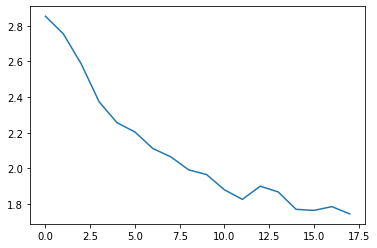

In [6]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i} {i/n_iters*100:.1f} {loss:.4f} {line} / {guess} {correct}")
        
plt.figure()
plt.plot(all_losses)
plt.show()

In [7]:
def predict(input_line):
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
            
        gess = category_from_output(output)
        return gess

In [9]:
predict('Erick')

'Arabic'

### Plot graph

In this example of a RNN model, we have a loop which is poping leters one by one, and processing separetly in the model. The model outputs 2 results, one of them is feed again to the model together with the new letter in the word until the complet name is procesed. The final output is the result. How does this affect in the computation graph?

In [36]:
line_tensor = line_to_tensor('tes')
hidden = rnn.init_hidden()

for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

g = make_dot(output)
g.view()

'Digraph.gv.pdf'